<a href="https://colab.research.google.com/github/nikorose87/TechChallengeSamay/blob/main/Notebooks/SamayColab/%5BNP%5D_Technical_assesment__Senior_ML_engineer_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://uploads-ssl.webflow.com/632f50e291252dcd1cf0c08b/63dc0565438858025d69245a_Samay-logo-gradient.png" width="30%">

# Comprehensive Technical Test:
## Lung Sound Analysis for Respiratory Health

# Part 2

---

The primary goal of this technical test is to design, develop, and optimize a machine learning solution for detecting and classifying *respiratory diseases*. This will be achieved using a dataset of lung sounds recorded with an electronic stethoscope. The comprehensive IPython Notebook delivered should demonstrate the *candidate's proficiency* in analyzing sensor data for health applications, specifically in the context of pulmonary diseases.

## Dataset description

The evolution of stethoscope technology has facilitated the high-quality recording of lung sounds from both healthy individuals and those with various pulmonary conditions. This dataset encompasses audio recordings from patients with seven different ailments, including asthma, heart failure, pneumonia, bronchitis, pleural effusion, lung fibrosis, and COPD, alongside normal breathing sounds. Recordings were taken from multiple positions on the chest, as determined by a specialist physician. Each sound was recorded thrice using different frequency filters to highlight specific bodily sounds. This valuable dataset supports the development of automated tools for diagnosing pulmonary diseases through lung sound analysis and can be extended to heart sound studies.

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S2352340921001979-gr1.jpg" width="50%">

The dataset comprises audio recordings of lung sounds from 112 subjects, captured using an electronic stethoscope. It includes data from 35 healthy individuals and 77 subjects with various respiratory diseases [1, 2, 3].
- **Content:** The audio recordings have been filtered through Bell, Diaphragm, and Extended modes to ensure clarity and precision in sound quality.
- **Annotations:** Each audio file is annotated with comprehensive details including the type of lung sound, the disease diagnosis, recording location on the subject's chest, as well as the age and gender of the subjects. This information is crucial for the analysis and classification tasks.

In [1]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# File System and Path Handling
import os
import pathlib
import warnings
warnings.filterwarnings('ignore')

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Signal Processing
import scipy
import scipy.io
import scipy.io.wavfile
from scipy import signal
from scipy.fft import fftshift
from scipy.io import wavfile
import scipy.io.wavfile

# Image Manipulation
import matplotlib.image as mpimg

# Miscellaneous
import ntpath
import random
from IPython import display
import time

# Audio Processing (Librosa)
import librosa.display
import soundfile as sf

# Importing required libraries for handling HTTP requests and zip files
import requests  # Library for making HTTP requests
import zipfile   # Library for handling zip files
import io        # Library for handling binary data streams

# 0. Installing dependencies

In [18]:
import sys

def install_in_case():
    if 'google.colab' in sys.modules:
        !pip install -U skorch
        !pip install optuna
        !pip install optuna-integration
        !pip install scikit-optimize
    else:
        print(f"Please install packages manually.")

install_in_case()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.3 MB/s eta 0:00:00


---

# 1. Loading the dataset

In [3]:
# Obtain the current working directory
current_path = os.getcwd()

# URL of the ZIP file to be downloaded
url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/jwyy9np4gv-3.zip"

# Download the ZIP file from the specified URL
response = requests.get(url)

# Check if the HTTP response status code is 200 (OK)
if response.status_code == 200:
    # Retrieve the content of the ZIP file
    zip_content = response.content

    # Extract the content of the ZIP file into a specific folder
    with zipfile.ZipFile(io.BytesIO(zip_content), 'r') as zip_ref:
        zip_ref.extractall("inputdata")  # Change this to the desired directory path
    print("File downloaded and extracted successfully.")
else:
    print("Error downloading the file.")

File downloaded and extracted successfully.


In [4]:
def extract_nested_zip(zip_file_path, extraction_path):
    """
    Extract a zip file, including any nested zip files.
    Delete the zip file after extraction.
    """
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the directory
        zip_ref.extractall(extraction_path)

        # Iterate through each file in the extracted files
        for file in zip_ref.namelist():
            # Check if the file is a zip file
            if file.endswith('.zip'):
                # Construct full path to the nested zip file
                nested_zip_path = os.path.join(extraction_path, file)

                # Recursively extract the nested zip file
                extract_nested_zip(nested_zip_path, extraction_path)

                # Optionally, remove the nested zip file after extraction
                os.remove(nested_zip_path)

In [5]:
dataset_path = current_path + "/inputdata/"  # Change this to the extraction path of the main ZIP file

# Look for ZIP files in the extraction directory and extract any nested ZIP files
for file in os.listdir(dataset_path):
    if file.endswith('.zip'):
        zip_file_path = os.path.join(dataset_path, file)
        extract_nested_zip(zip_file_path, dataset_path)

# Define the path to the dataset directory
data_dir = pathlib.Path(dataset_path)

# List the files in the directory
commands = np.array(os.listdir(data_dir))

# Filter and remove 'README.md' from the list of files
commands = commands[commands != 'README.md']

# Split each element in the list by commas, and then by underscores
a = [line.split(',') for line in commands]
b = [x[0].split('_') for x in a]

# Extract the label only if the element has at least two parts
label = [c[1] for c in b if len(c) > 1]

# Convert labels to lowercase
label = [x.lower() for x in label]

# Iterate through the labels and perform label consolidation
for i in range(336):
    if label[i] == 'asthma and lung fibrosis':
        label[i] = 'asthma'
    elif label[i] == 'heart failure + copd' or label[i] == 'heart failure + lung fibrosis ':
        label[i] = 'heart failure'
    elif label[i] == 'plueral effusion' or label[i] == 'bron':
        label[i] = 'others'
    else:
        label[i] = label[i]

def return_unique_labels(labels):
    # Removing duplicates from the list while maintaining the order
    unique_labels = []
    for label in labels:
        if label not in unique_labels:
            unique_labels.append(label)
    return unique_labels

labels = return_unique_labels(label)

# Initialize an empty array to store the full paths of WAV files
wav_files = []

# Iterate through the files in the directory
for file in os.listdir(dataset_path):
    # Check if the file is a WAV file
    if file.endswith(".wav"):
        # Add the full path of the file to the array
        wav_files.append(os.path.join(dataset_path, file))

# Initialize an array to store the data of each WAV file
wav_data = []

# Iterate through the WAV file paths in the wav_files array
for filepath in wav_files:
    # Read the WAV file using scipy.io.wavfile
    sample_rate, data = scipy.io.wavfile.read(filepath)

    # Add the data, sample rate, file path, and data type to the wav_data array
    wav_data.append({
        "file_path": filepath,
        "sample_rate": sample_rate,
        "data": data,
        "data_type": data.dtype
    })


# Ensure the number of labels matches the number of WAV files
assert len(label) == len(wav_data)

# Extracting only the 'data' from each WAV file
data_values = [item['data'] for item in wav_data]

# Creating a DataFrame with 'data' and 'label'
sound_df = pd.DataFrame({
    'data': data_values,  # Column 'data' containing waveform data arrays
    'label': label        # Column 'label' containing labels
})
sound_df.sample(3)

,data,label
233,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 12, 18...",n
270,"[0, 0, -2, -7, 10, 106, 285, 432, 444, 355, 28...",copd
131,"[0, 0, 0, 0, 2, 16, 47, 87, 117, 133, 147, 168...",copd


In [6]:
# Display the unique labels and their counts
sound_df['label'].value_counts()

label
n                105
asthma            99
heart failure     63
copd              27
others            15
pneumonia         15
lung fibrosis     12
Name: count, dtype: int64

---

# Machine Learning Algorithm Design and Validation


In [7]:
def pad_audio_data(audio_data, target_length):
    # Calculate the number of zeros to add
    padding = target_length - len(audio_data)

    # Add zeros at the end of the audio data
    padded_data = np.pad(audio_data, (0, padding), 'constant')
    return padded_data
# Determine the maximum length of audio data in the dataset
max_length = max([len(data) for data in sound_df['data']])
print(f"Maximum length of audio data: {max_length}")
# Pad the audio data
sound_df['data'] = sound_df['data'].apply(lambda x: pad_audio_data(x, max_length))
print(f"Shape of the audio data: {(sound_df['data'].shape[0], sound_df['data'][0].shape[0])}")
sound_df.sample(3)

Maximum length of audio data: 120000
Shape of the audio data: (336, 120000)


,data,label
163,"[0, 0, 0, 0, -1, -1, 2, 8, 16, 30, 38, 21, -46...",asthma
45,"[0, -1, -4, 5, 36, 74, 176, 443, 774, 976, 105...",n
224,"[0, 0, 0, 0, 0, 0, -1, -1, 0, 2, 7, 17, 32, 53...",n


## Machine Learning process with the provided Dataset

The dataset provided replicates the subjects by three. In other words, is redundant, the filter audios (B, D and E) per subject are combined in the same bag. Then, the data exists three times for the same subject and the ML algorithm is not taking advantage of this categorization, including location, sound type or filter.

However, let us see how it goes.

## Preprocessing

We will split the array in each column and generate multiple features. As a second step, we will reduce the dataset with PCA or t-SNE for dimensionality reduction and later see which ML algorithm to apply.

### Generating multiple features


In [8]:
# Convert the 'data' column to a 2D array
data = np.stack(sound_df['data'].values)

# Convert the 2D array to a DataFrame
data_df = pd.DataFrame(data)

# Concatenate the original DataFrame with the new DataFrame
sound_df = pd.concat([sound_df, data_df], axis=1)
sound_df.drop('data', axis=1, inplace=True)
sound_df.sample(3)

,label,0,1,2,3,4,5,6,7,8,...,119990,119991,119992,119993,119994,119995,119996,119997,119998,119999
294,copd,0,0,0,0,0,-1,-1,-1,1,...,0,0,0,0,0,0,0,0,0,0
85,n,0,0,0,0,0,3,3,-7,-19,...,0,0,0,0,0,0,0,0,0,0
93,others,-16,25,125,88,-41,-111,-93,-11,44,...,0,0,0,0,0,0,0,0,0,0


### Minimizing the dimensionality course problem

Let us create only three features with the 120K features and see how the model behaves


In [9]:
from sklearn.decomposition import PCA

# Select the columns from 0 to 119999
data = sound_df.loc[:, 0: 119999]

# Define the number of components for PCA
num_PCA = 100

# Initialize a PCA model
pca = PCA(n_components=num_PCA)

# Fit the PCA model on the data
pca.fit(data)

# Transform the data using the fitted PCA model
transformed_data = pca.transform(data)

# Add the transformed data as new columns in the DataFrame
for i in range(transformed_data.shape[1]):
    sound_df[f'PCA{i+1}'] = transformed_data[:, i]

# Remove the original data columns
sound_df.drop(sound_df.loc[:, 0: 119999].columns, axis=1, inplace=True)
sound_df.sample(3)

,label,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,...,PCA91,PCA92,PCA93,PCA94,PCA95,PCA96,PCA97,PCA98,PCA99,PCA100
7,heart failure,-15120.050248,-7126.764879,-3962.169860,-14829.746273,-25679.132950,-49915.341551,-12774.690274,2272.865787,-12919.938729,...,2284.526280,-9636.589649,-7914.972452,-2710.518737,13952.470388,-2457.123359,12570.022012,-5380.969884,8915.501393,15418.748990
173,asthma,32722.674300,-33931.048325,-51985.022405,24508.164299,-10730.228699,-5030.759783,-30063.937739,19225.712728,-33670.000020,...,-25520.194357,8082.360336,4331.731961,47489.460025,10647.664928,-6321.785088,-6209.192934,75710.079793,-10137.475232,-92704.637349
318,lung fibrosis,-135736.087143,65874.830107,-19297.848374,11002.607208,-31690.979052,-20848.884652,2052.391213,-44049.374655,18365.038094,...,-26859.776646,1193.816444,-34432.724614,10100.071920,-16151.303918,-166.660234,-14487.799493,-4239.691071,-18080.062856,172.671086


Printing the dimensions to see if they can be differenciated visually

### Performing the ML model

Let us see if the generated PCA values can add with the created model in the last part of the evaluation. At first I am going to create the helper function to apply the same model

---

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Encode the target variable
le = LabelEncoder()

# Define the features and the target
X = sound_df.drop(columns='label')
y = le.fit_transform(sound_df['label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Base NN model

We will propose Deep Neural Networks for this model

               precision    recall  f1-score   support

       asthma       0.89      0.77      0.83        31
         copd       0.78      1.00      0.88         7
heart failure       0.67      0.80      0.73        20
lung fibrosis       0.75      0.43      0.55         7
            n       0.85      0.85      0.85        26
       others       0.50      1.00      0.67         4
    pneumonia       1.00      0.50      0.67         6

     accuracy                           0.78       101
    macro avg       0.78      0.76      0.74       101
 weighted avg       0.81      0.78      0.78       101



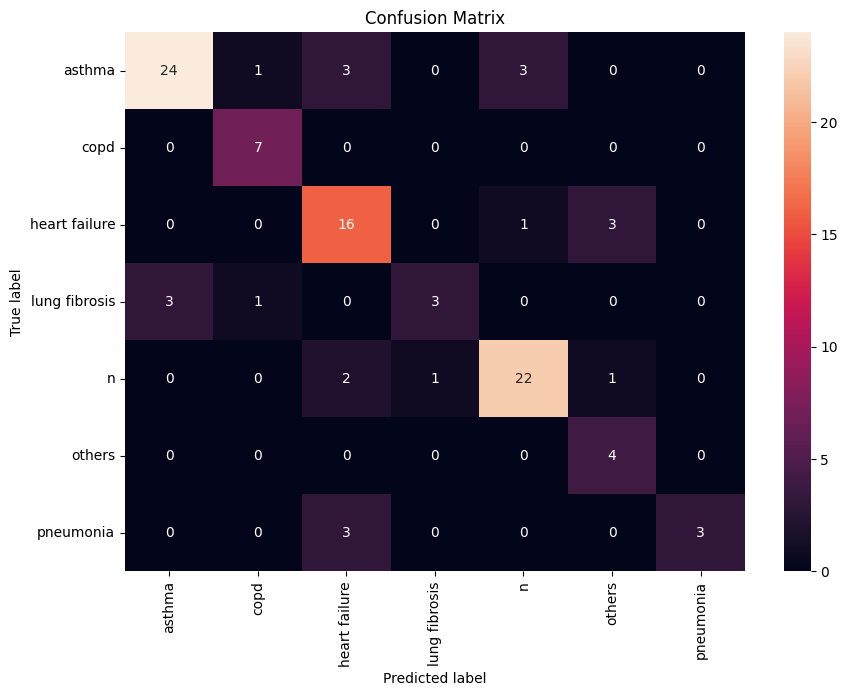

In [11]:
import torch
from torch import nn
from sklearn.metrics import confusion_matrix, classification_report
from typing import List, Literal

verbose = False
num_epochs = 1000

class SNN(nn.Module):
    def __init__(self, input_size:int, hidden_size:int,
                 activation:Literal["relu", "sigm", "tanh"], num_classes:int):
        """__init__ method for the SNN class
        Args:
            input_size (int): Number of input features
            hidden_size (int): Number of neurons in the hidden layers
            activation (Literal["relu", "sigm", "tanh"]): Activation function to use
            num_classes (int): Number of output classes
        """
        super(SNN, self).__init__()
        self.activation = {"relu": nn.ReLU(),
                           "sigm": nn.Sigmoid(),
                           "leaky_relu": nn.LeakyReLU()}
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.act = self.activation[activation]
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        seq = self.fc1(x)
        seq = self.act(seq)
        seq = self.fc2(seq)
        seq = self.act(seq)
        seq = self.fc3(seq)
        return seq

# Define the network dimensions
input_size = num_PCA  # Number of input features (100 PCA features)
hidden_size = 50  # Number of neurons in the hidden layers
num_classes = len(labels)  # Number of output classes (change this to match your number of classes)

# Initialize the network
net = SNN(input_size, hidden_size, "relu", num_classes)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Convert the training data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Train the model
for epoch in range(num_epochs):  # Number of epochs
    # Forward pass
    outputs = net(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0 and verbose:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Convert the test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Get the model's predictions on the test set
y_pred_tensor = net(X_test_tensor)
_, y_pred = torch.max(y_pred_tensor.data, 1)

# Convert the predictions and the true labels back to their original form
y_test_labels = le.inverse_transform(y_test_tensor)
y_pred_labels = le.inverse_transform(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Create the figure
fig, ax = plt.subplots(figsize=(10,7))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
ax.set_title('Confusion Matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_xticks(ticks=np.arange(len(le.classes_))+0.5)
ax.set_xticklabels(labels=le.classes_, rotation=90, fontsize=10)
ax.set_yticks(ticks=np.arange(len(le.classes_))+0.5)
ax.set_yticklabels(labels=le.classes_, rotation=0, fontsize=10)

# Compute the classification report
report = classification_report(y_test_labels, y_pred_labels)

# Print the classification report
print(report)

# Show the confusion matrix
plt.show()

### Helper Functions


In [12]:
from torch.nn import functional as F
from skorch import NeuralNetClassifier
import optuna
from optuna.integration import SkorchPruningCallback

class HyperparameterTuner:
    def __init__(self, X_train, y_train, X_test, y_test, num_classes):
        """_method for the HyperparameterTuner class_
        Args:
            X_train (pd.DataFrame): Training features
            y_train (pd.Series): Training target
            X_test (pd.DataFrame): Testing features
            y_test (pd.Series): Testing target
            num_classes (int): Number of output classes
        """
        self.X_train = torch.tensor(X_train.values, dtype=torch.float)
        self.y_train = torch.tensor(y_train, dtype=torch.long)
        self.X_test = torch.tensor(X_test.values, dtype=torch.float)
        self.y_test = torch.tensor(y_test, dtype=torch.long)
        self.num_classes = num_classes
        self.study = None

    def objective(self, trial):
        """
        Objective function for the Optuna hyperparameter optimization
        Args:
            trial (optuna.trial): Optuna trial object
        Returns:
            float: Score to minimize or maximize
        """
        lr = trial.suggest_loguniform('lr', 1e-6, 1e-1)
        hidden_size = trial.suggest_int('hidden_size', 10, 1000)
        max_epochs = trial.suggest_int('max_epochs', 100, 1000)
        activation_opt = trial.suggest_categorical('activation', ['relu', 'sigm', 'leaky_relu'])

        # Define the model
        model = NeuralNetClassifier(
            SNN,
            module__input_size=X_train.shape[1],
            module__hidden_size=hidden_size,
            module__num_classes=self.num_classes,
            module__activation=activation_opt,
            max_epochs=max_epochs,
            lr=lr,
            optimizer=torch.optim.Adam,
            criterion=nn.CrossEntropyLoss,
            device='cuda' if torch.cuda.is_available() else 'cpu',
            callbacks=[SkorchPruningCallback(trial, 'valid_loss')],
            verbose=0
        )

        # Train the model
        model.fit(self.X_train, self.y_train)

        # Evaluate the model
        score = model.score(self.X_test, self.y_test)

        return score

    def tune(self):
        """
        Perform the hyperparameter optimization using Optuna
        Returns:
            dict: Best hyperparameters
        """
        self.study = optuna.create_study(direction='maximize')
        self.study.optimize(self.objective, n_trials=50)

        return self.study.best_params

    def train_best_model(self):
        """
        Train the model using the best hyperparameters
        Returns:
            NeuralNetClassifier: Trained model
        """
        # Get the best hyperparameters
        best_params = self.study.best_params

        # Train the model with the best hyperparameters
        best_model = NeuralNetClassifier(
            SNN,
            module__input_size=self.X_train.shape[1],
            module__hidden_size=best_params['hidden_size'],
            module__num_classes=self.num_classes,
            module__activation=best_params['activation'],
            max_epochs=best_params['max_epochs'],
            lr=best_params['lr'],
            optimizer=torch.optim.Adam,
            criterion=nn.CrossEntropyLoss,
            device='cuda' if torch.cuda.is_available() else 'cpu',
            verbose=0
        )
        best_model.fit(self.X_train, self.y_train)
        return best_model

    def plot_confusion_matrix(self, y_true, y_pred, le):
        """
        Plot the confusion matrix
        Args:
            y_true (np.array): True labels
            y_pred (np.array): Predicted labels
            le (LabelEncoder): LabelEncoder object
        """
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Plot the confusion matrix
        fig, ax = plt.subplots(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', ax=ax)
        ax.set_title('Confusion Matrix')
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')
        ax.set_xticks(ticks=np.arange(len(le.classes_))+0.5)
        ax.set_xticklabels(labels=le.classes_, rotation=90, fontsize=10)
        ax.set_yticks(ticks=np.arange(len(le.classes_))+0.5)
        ax.set_yticklabels(labels=le.classes_, rotation=0, fontsize=10)

        plt.show()

    def print_classification_report(self, y_true, y_pred):
        """
        Print the classification report
        Args:
            y_true (np.array): True labels
            y_pred (np.array): Predicted labels
        """
        # Compute the classification report
        report = classification_report(y_true, y_pred)

        # Print the classification report
        print(report)

    def plot_results(self, le):
        """
        Plot the confusion matrix and print the classification report
        Args:
            le (LabelEncoder): LabelEncoder object
        """
        best_model = self.train_best_model()
        y_pred = best_model.predict(self.X_test)
        self.plot_confusion_matrix(self.y_test, y_pred, le)
        self.print_classification_report(self.y_test, y_pred)

Evaluating the model

In [13]:
Tuner = HyperparameterTuner(X_train, y_train, X_test, y_test, len(np.unique(y_train)))
best_params = Tuner.tune()
best_params

[I 2024-05-05 21:27:45,963] A new study created in memory with name: no-name-2db59491-5702-4ffe-879e-85535d3d3821
[I 2024-05-05 21:27:52,721] Trial 0 finished with value: 0.8316831683168316 and parameters: {'lr': 0.02378584041780355, 'hidden_size': 255, 'max_epochs': 685, 'activation': 'leaky_relu'}. Best is trial 0 with value: 0.8316831683168316.
[I 2024-05-05 21:27:59,477] Trial 1 finished with value: 0.6237623762376238 and parameters: {'lr': 1.9556182279878488e-05, 'hidden_size': 864, 'max_epochs': 713, 'activation': 'leaky_relu'}. Best is trial 0 with value: 0.8316831683168316.
[I 2024-05-05 21:28:02,028] Trial 2 finished with value: 0.7920792079207921 and parameters: {'lr': 0.0019558869491173823, 'hidden_size': 82, 'max_epochs': 278, 'activation': 'leaky_relu'}. Best is trial 0 with value: 0.8316831683168316.
[I 2024-05-05 21:28:09,957] Trial 3 finished with value: 0.37623762376237624 and parameters: {'lr': 4.30242657753359e-06, 'hidden_size': 233, 'max_epochs': 969, 'activation':

{'lr': 0.05041797542551741,
 'hidden_size': 770,
 'max_epochs': 294,
 'activation': 'leaky_relu'}

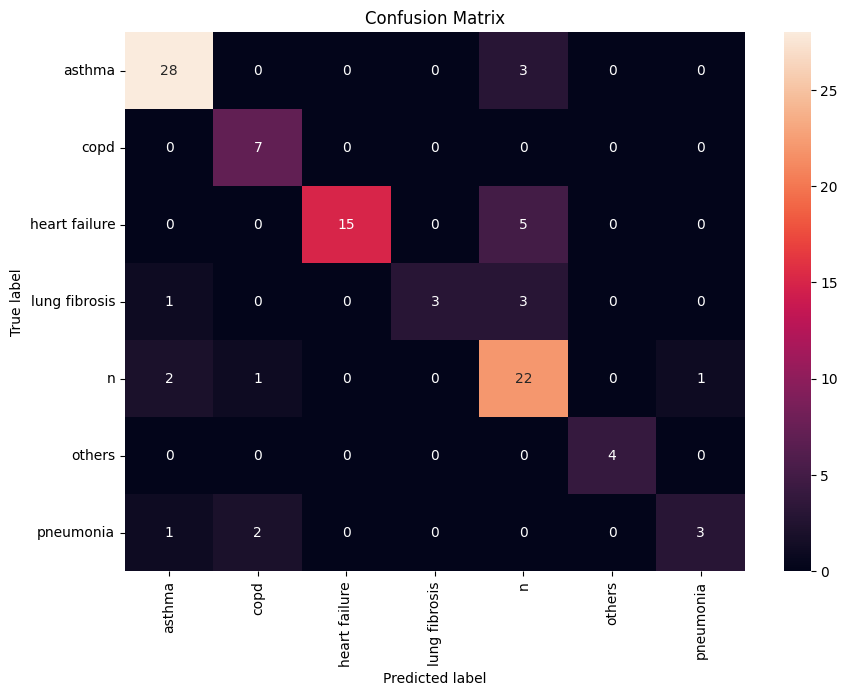

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        31
           1       0.70      1.00      0.82         7
           2       1.00      0.75      0.86        20
           3       1.00      0.43      0.60         7
           4       0.67      0.85      0.75        26
           5       1.00      1.00      1.00         4
           6       0.75      0.50      0.60         6

    accuracy                           0.81       101
   macro avg       0.86      0.78      0.79       101
weighted avg       0.84      0.81      0.81       101



In [14]:
Tuner.plot_results(le=le)


## Part B (My data)

As you may know, I concatenated the MFCC numbers for the given filters (B,D and E) in one row. This is the main difference with the dataset you provided. Let us see how it behaves with the same neural network architecture.

Let us load the dataset generated in the previous notebook:

In [15]:
df_wide = pd.read_csv('https://raw.githubusercontent.com/nikorose87/TechChallengeSamay/main/dataset/processed_data.csv', index_col=0)
df_wide.sample(4)

,0_B,0_D,0_E,1_B,1_D,1_E,2_B,2_D,2_E,3_B,...,24_B,24_D,24_E,25_B,25_D,25_E,Diagnosis,SoundType,Location,Gender
SubjectNo,,,,,,,,,,,,,,,,,,,,,
41,-440.11703,-359.08774,-368.54684,96.46067,158.62184,158.61472,87.207820,77.886790,65.589460,74.158600,...,-1.157481,0.624551,1.224705,-0.110593,1.133527,1.739248,pneumonia,Crep,P R M,M
72,-464.62630,-412.53310,-433.67360,54.74962,96.79309,94.81869,51.224228,51.110160,41.994137,46.515297,...,-0.763629,1.785167,1.727988,-0.335942,2.561264,2.199973,N,N,P R U,F
2,-418.02680,-343.32623,-337.45060,114.72748,190.22578,185.01903,92.624435,54.114290,42.400290,67.337006,...,0.111165,0.520993,2.148090,0.996446,2.081771,2.299990,Asthma,E W,P L L R,F
35,-400.44977,-337.32750,-325.22614,87.68938,166.41151,158.90446,78.824646,42.885715,31.489720,66.966400,...,-0.171870,0.183132,1.938797,0.775603,2.492253,2.777224,Asthma,E W,A R L,M


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
le = LabelEncoder()

# Define the features and the target
X = df_wide.drop(columns='Diagnosis')
# Transform the categorical variables
X['SoundType'] = le.fit_transform(X['SoundType'])
X['Location'] = le.fit_transform(X['Location'])
X['Gender'] = le.fit_transform(X['Gender'])
# Encode the target variable
y = le.fit_transform(df_wide['Diagnosis'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [25]:
from skopt import BayesSearchCV
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softprob',
                            eval_metric='mlogloss')

# Define the search space for the hyperparameters
search_space = {'max_depth': (1, 20),
                'gamma': (0.0, 10.0),
                'n_estimators': (10, 1000),
                'min_child_weight': (1, 20),
                'learning_rate': (0, 10.0)}

# Define the cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize the Bayesian optimization object
opt = BayesSearchCV(xgb_clf, search_space, cv=cv, n_iter=15, random_state=42,
                    n_jobs=-1, verbose=1, scoring='f1_micro')

# Resampling did not work here
opt.fit(X_train, y_train)

# printing best parameters
print(opt.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
OrderedDict([('gamma', 4.019988755427103), ('learning_rate', 9.910784952123555), ('max_depth', 20), ('min_child_wei

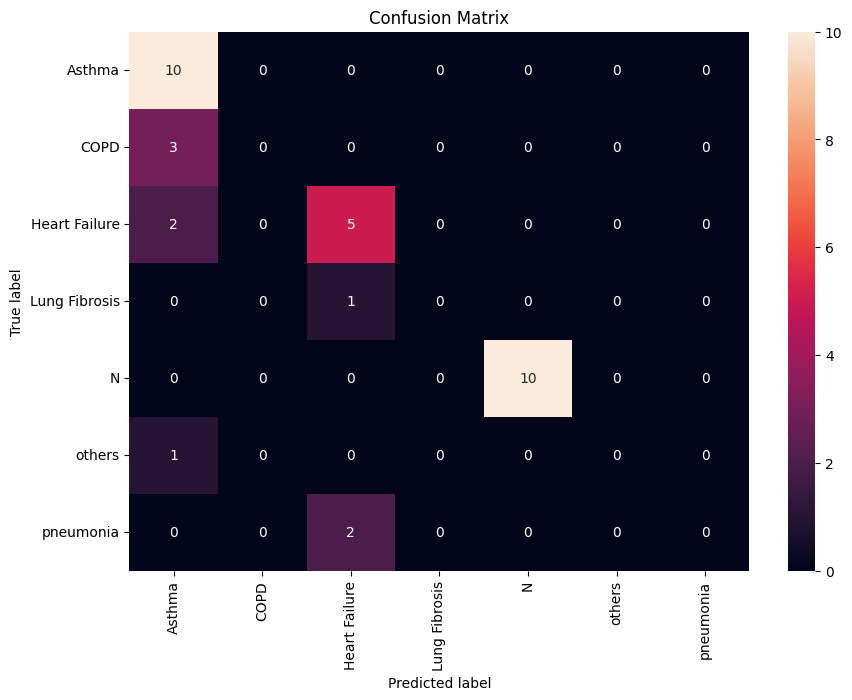

               precision    recall  f1-score   support

       Asthma       0.62      1.00      0.77        10
         COPD       0.00      0.00      0.00         3
Heart Failure       0.62      0.71      0.67         7
Lung Fibrosis       0.00      0.00      0.00         1
            N       1.00      1.00      1.00        10
       others       0.00      0.00      0.00         1
    pneumonia       0.00      0.00      0.00         2

     accuracy                           0.74        34
    macro avg       0.32      0.39      0.35        34
 weighted avg       0.61      0.74      0.66        34



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the classes on the test set
y_pred = opt.predict(X_test)

# Convert the encoded labels back to their original form
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(ticks=np.arange(len(le.classes_))+0.5, labels=le.classes_, rotation=90)
plt.yticks(ticks=np.arange(len(le.classes_))+0.5, labels=le.classes_, rotation=0)
plt.show()

# Print the classification report
print(classification_report(y_test_labels, y_pred_labels))

# Conclusions

Main conclusions are given in the report.